In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import display
from scipy.stats import ttest_ind

# Load the dataset
df = pd.read_csv('Goldman_Sachs.csv')

# Data
df.head()

,TransactionID,CustomerID,AccountID,AccountType,TransactionType,Product,Firm,Region,Manager,TransactionDate,TransactionAmount,AccountBalance,RiskScore,CreditRating,TenureMonths
0,33,CUST6549,ACC12334,Credit,Withdrawal,Savings Account,Firm C,Central,Manager 1,21-10-2023,87480.05448,74008.43310,0.729101,319,200
1,177,CUST2942,ACC52650,Credit,Withdrawal,Home Loan,Firm A,East,Manager 3,20-06-2023,20315.74505,22715.83590,0.472424,692,47
2,178,CUST6776,ACC45101,Current,Deposit,Personal Loan,Firm C,South,Manager 3,02-01-2023,10484.57165,42706.09210,0.648784,543,109
3,173,CUST2539,ACC88252,Current,Withdrawal,Mutual Fund,Firm A,Central,Manager 2,25-07-2023,45122.27373,114176.56870,0.734832,430,103
4,67,CUST2626,ACC21878,Savings,Withdrawal,Home Loan,Firm C,Central,Manager 4,25-07-2023,42360.79878,17863.02644,0.289304,468,234


### Task : 1 Data Cleaning and Formatting

In [20]:
# Convert Date column to datetime objects
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], dayfirst=True)

# 2. Extract only the Date part (removes 00:00:00)
df['TransactionDate'] = df['TransactionDate'].dt.date

# Check for missing values
print(df.isnull().sum())

TransactionID        0
CustomerID           0
AccountID            0
AccountType          0
TransactionType      0
Product              0
Firm                 0
Region               0
Manager              0
TransactionDate      0
TransactionAmount    0
AccountBalance       0
RiskScore            0
CreditRating         0
TenureMonths         0
dtype: int64


In [ ]:
# Convert all values in 'TransactionAmount' to positive
df['TransactionAmount'] = df['TransactionAmount'].abs()

# Verification
df.head()

# Check data types of all columns
print(df.dtypes)

TransactionID                 int64
CustomerID                   object
AccountID                    object
AccountType                  object
TransactionType              object
Product                      object
Firm                         object
Region                       object
Manager                      object
TransactionDate      datetime64[ns]
TransactionAmount           float64
AccountBalance              float64
RiskScore                   float64
CreditRating                  int64
TenureMonths                  int64
dtype: object


In [ ]:
# Should return positive value
print(df['TransactionAmount'].min())

375.4909042


In [ ]:
# Check standardisation of columns
print("Account Types:", df['AccountType'].unique())
print("Transaction Types:", df['TransactionType'].unique())

Account Types: ['Credit' 'Current' 'Savings' 'Loan']
Transaction Types: ['Withdrawal' 'Deposit' 'Payment' 'Transfer']


In [ ]:
# Save the cleaned Excel file

df.to_excel('Goldman_Sachs_Cleaned.xlsx', index=False)

print("Cleaned dataset saved successfully to Excel.")

Cleaned dataset saved successfully to Excel.


### Task : 2 Descriptive Transactional Analysis

(800, 15)
   TransactionID CustomerID AccountID AccountType TransactionType  \
0             33   CUST6549  ACC12334      Credit      Withdrawal   
1            177   CUST2942  ACC52650      Credit      Withdrawal   
2            178   CUST6776  ACC45101     Current         Deposit   
3            173   CUST2539  ACC88252     Current      Withdrawal   
4             67   CUST2626  ACC21878     Savings      Withdrawal   
5             96   CUST4684  ACC45101     Savings         Deposit   
6             57   CUST8416  ACC49422        Loan         Deposit   
7             27   CUST9731  ACC12182        Loan         Payment   
8             25   CUST8155  ACC11188      Credit      Withdrawal   
9            138   CUST2067  ACC28292      Credit         Deposit   

           Product    Firm   Region    Manager TransactionDate  \
0  Savings Account  Firm C  Central  Manager 1      2023-10-21   
1        Home Loan  Firm A     East  Manager 3      2023-06-20   
2    Personal Loan  Firm C    So

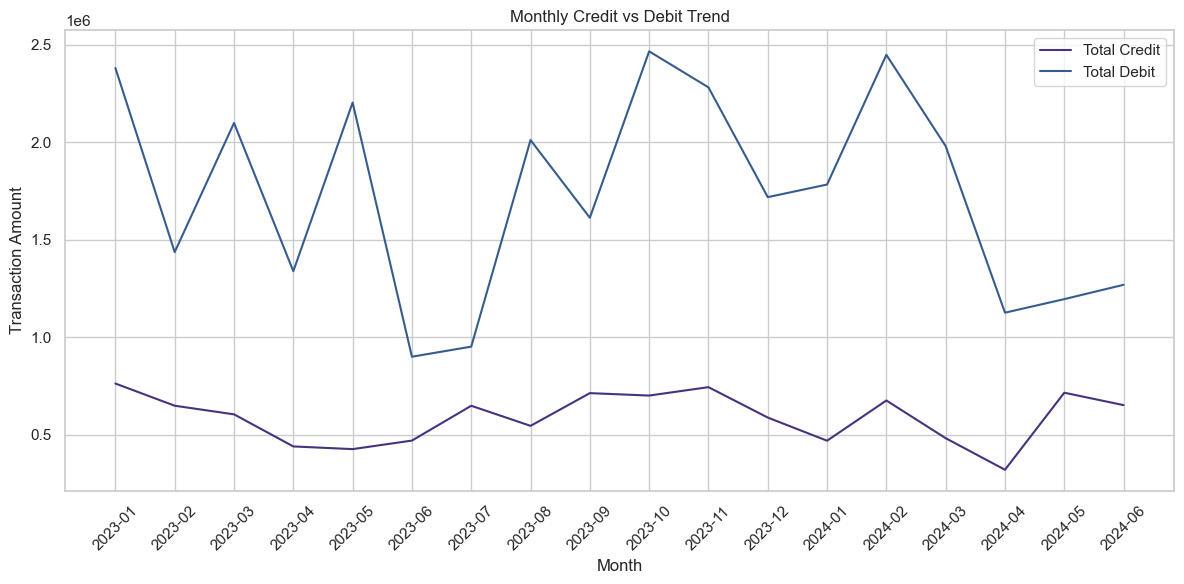

,Total_Credit,Total_Debit,Net_Transaction
Month,,,
2023-01,762099.557830,2.380984e+06,-1.618885e+06
2023-02,648261.004850,1.436502e+06,-7.882407e+05
2023-03,604002.422140,2.098983e+06,-1.494981e+06
2023-04,439321.687687,1.338294e+06,-8.989726e+05
2023-05,425589.871840,2.203715e+06,-1.778125e+06


,Total_Credit,Total_Debit,Net_Transaction
Year,,,
2023,7.285849e+06,2.139995e+07,-1.411410e+07
2024,3.311426e+06,9.801039e+06,-6.489613e+06


In [ ]:
# ============================================================
# TASK 2: DESCRIPTIVE TRANSACTIONAL ANALYSIS
# ============================================================
# Objectives:
# 1. Calculate monthly and yearly summaries of:
#    - Total credits
#    - Total debits
#    - Net transaction volume
# 2. Visualize credit vs debit trends over time
# ============================================================



# STEP 1: Load  dataset

df = pd.read_excel("Goldman_Sachs_Cleaned.xlsx")
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

print(df.shape)
print(df.head(10))



# STEP 2: Year and Month columns

df['Year'] = df['TransactionDate'].dt.year
df['Month'] = df['TransactionDate'].dt.to_period('M')

print("\nYear & Month columns")
print(df[['TransactionDate', 'Year', 'Month']].head())



# STEP 3: Credit and Debit values

# - Credit  → Deposit
# - Debit   → Withdrawal, Payment, Transfer

df['Credit'] = 0
df['Debit'] = 0

df.loc[df['TransactionType'] == 'Deposit', 'Credit'] = df['TransactionAmount']
df.loc[df['TransactionType'].isin(['Withdrawal', 'Payment', 'Transfer']), 'Debit'] = df['TransactionAmount']

print("\nCredit & Debit check")
print(df[['TransactionType', 'TransactionAmount', 'Credit', 'Debit']].head())



# STEP 4: Monthly Transaction Summary

monthly_summary = df.groupby('Month').agg(
    Total_Credit=('Credit', 'sum'),
    Total_Debit=('Debit', 'sum')
)

monthly_summary['Net_Transaction'] = (
    monthly_summary['Total_Credit'] - monthly_summary['Total_Debit']
)

monthly_summary.index = monthly_summary.index.astype(str)

print("\nMonthly summary")
print(monthly_summary.head())



# STEP 5: Yearly Transaction Summary

yearly_summary = df.groupby('Year').agg(
    Total_Credit=('Credit', 'sum'),
    Total_Debit=('Debit', 'sum')
)

yearly_summary['Net_Transaction'] = (
    yearly_summary['Total_Credit'] - yearly_summary['Total_Debit']
)

print("\nYearly summary")
print(yearly_summary)



# STEP 6: Save Task to Excel

with pd.ExcelWriter("Task_2_Transactional_Summary.xlsx", engine="openpyxl") as writer:
    monthly_summary.to_excel(writer, sheet_name="Monthly_Summary")
    yearly_summary.to_excel(writer, sheet_name="Yearly_Summary")

print("\nExcel file (Task_2_Transactional_Summary.xlsx)")



# STEP 7: Credit vs Debit Trend Graph (Monthly)

plt.figure()
plt.plot(monthly_summary.index, monthly_summary['Total_Credit'], label='Total Credit')
plt.plot(monthly_summary.index, monthly_summary['Total_Debit'], label='Total Debit')
plt.title("Monthly Credit vs Debit Trend")
plt.xlabel("Month")
plt.ylabel("Transaction Amount")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.savefig("Task_2_Credit_vs_Debit_Trend.png")
plt.show()




# FINAL: DISPLAY OUTPUT TABLES 

display(monthly_summary.head())
display(yearly_summary)


### Task : 3 Customer Profile Building

Dataset
(800, 15)
   TransactionID CustomerID AccountID AccountType TransactionType  \
0             33   CUST6549  ACC12334      Credit      Withdrawal   
1            177   CUST2942  ACC52650      Credit      Withdrawal   
2            178   CUST6776  ACC45101     Current         Deposit   
3            173   CUST2539  ACC88252     Current      Withdrawal   
4             67   CUST2626  ACC21878     Savings      Withdrawal   
5             96   CUST4684  ACC45101     Savings         Deposit   
6             57   CUST8416  ACC49422        Loan         Deposit   
7             27   CUST9731  ACC12182        Loan         Payment   
8             25   CUST8155  ACC11188      Credit      Withdrawal   
9            138   CUST2067  ACC28292      Credit         Deposit   

           Product    Firm   Region    Manager TransactionDate  \
0  Savings Account  Firm C  Central  Manager 1      2023-10-21   
1        Home Loan  Firm A     East  Manager 3      2023-06-20   
2    Personal Loan  Firm

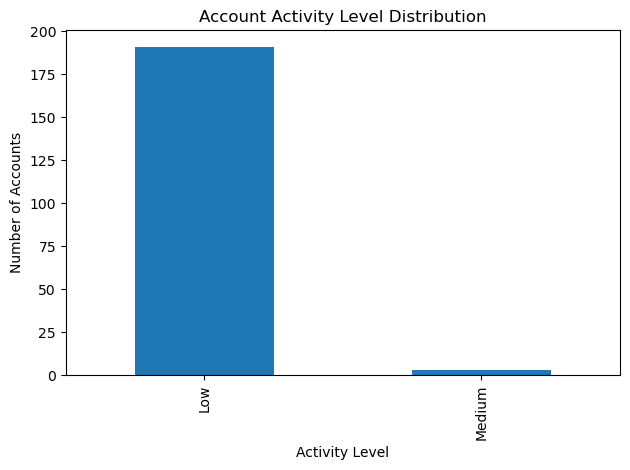

Activity level distribution graph


,AccountID,Transaction_Count,Activity_Level
0,ACC10117,4,Low
1,ACC10996,5,Low
2,ACC11062,2,Low
3,ACC11188,5,Low
4,ACC11285,3,Low


,AccountID,Avg_Balance,Total_Transaction_Amount,Transaction_Count,Activity_Level
0,ACC10117,70107.007957,199480.967430,4,Low
1,ACC10996,43568.008084,250739.550950,5,Low
2,ACC11062,38137.132610,27189.136160,2,Low
3,ACC11188,69652.151044,257576.603590,5,Low
4,ACC11285,97401.348560,96729.609841,3,Low


,AccountID,Avg_Balance,Total_Transaction_Amount,Transaction_Count,Activity_Level
1,ACC10996,43568.008084,250739.55095,5,Low
3,ACC11188,69652.151044,257576.60359,5,Low
7,ACC12334,78082.517883,310227.28969,6,Low
8,ACC13357,69179.806513,432527.80826,6,Low
9,ACC15228,95389.614144,277925.43736,5,Low


,AccountID,Avg_Balance,Total_Transaction_Amount,Transaction_Count,Activity_Level
1,ACC10996,43568.008084,250739.55095,5,Low
3,ACC11188,69652.151044,257576.60359,5,Low
8,ACC13357,69179.806513,432527.80826,6,Low
18,ACC18177,63505.219474,249580.48543,5,Low
29,ACC23736,60801.533102,309797.64287,7,Low


,AccountID,Avg_Balance,Total_Transaction_Amount,Transaction_Count,Activity_Level
20,ACC19178,-1541.176812,64100.78213,1,Low


In [6]:
# ============================================================
# TASK 3: CUSTOMER PROFILE BUILDING
# ============================================================
# Objectives:
# 1. Group accounts by activity levels (High / Medium / Low)
#    based on transaction frequency.
#
#    Activity Level Rubric:
#    - High   : More than 20 transactions
#    - Medium : 10 to 20 transactions
#    - Low    : Less than 10 transactions
#
# 2. Segment customers using:
#    - Average account balance
#    - Total transaction volume
#
# 3. Create customer profiles:
#    a) High-net inflow accounts
#    b) High-frequency low-balance accounts
#    c) Negative or near-zero balance accounts
# ============================================================


df = pd.read_excel("Goldman_Sachs_Cleaned.xlsx")
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])


# STEP 1: Load dataset


print("Dataset")
print(df.shape)
print(df.head(10))



# STEP 2: Transaction frequency per account

transaction_freq = df.groupby('AccountID').size().reset_index(name='Transaction_Count')

print("\nTransaction frequency")
print(transaction_freq.head())



# STEP 3: Assign activity levels using rubric

def activity_level(count):
    if count > 20:
        return 'High'
    elif count >= 10:
        return 'Medium'
    else:
        return 'Low'

transaction_freq['Activity_Level'] = transaction_freq['Transaction_Count'].apply(activity_level)

print("\nActivity level distribution")
print(transaction_freq['Activity_Level'].value_counts())



# STEP 4: Merge

df = df.merge(transaction_freq, on='AccountID', how='left')

print("\nDataset after merging")
print(df[['AccountID', 'Transaction_Count', 'Activity_Level']].head())



# STEP 5: Customer-level summary (segmentation base)

customer_summary = df.groupby('AccountID').agg(
    Avg_Balance=('AccountBalance', 'mean'),
    Total_Transaction_Amount=('TransactionAmount', 'sum'),
    Transaction_Count=('TransactionAmount', 'count'),
    Activity_Level=('Activity_Level', 'first')
).reset_index()

print("\nCustomer summary")
print(customer_summary.head())



# STEP 6: High-net inflow accounts

# - Total transaction amount > average of all accounts

avg_inflow = customer_summary['Total_Transaction_Amount'].mean()

high_net_inflow = customer_summary[
    customer_summary['Total_Transaction_Amount'] > avg_inflow
]

print("\nHigh-net inflow accounts")
print("Count:", high_net_inflow.shape[0])
print(high_net_inflow.head())



# STEP 7: High-frequency low-balance accounts

# - Transaction count > average transaction count
# - Average balance < overall average balance

avg_txn_count = customer_summary['Transaction_Count'].mean()
avg_balance = customer_summary['Avg_Balance'].mean()

high_freq_low_balance = customer_summary[
    (customer_summary['Transaction_Count'] > avg_txn_count) &
    (customer_summary['Avg_Balance'] < avg_balance)
]

print("\nHigh-frequency low-balance accounts")
print("Count:", high_freq_low_balance.shape[0])
print(high_freq_low_balance.head())



# STEP 8: Negative or near-zero balance accounts

# - Average balance ≤ 1000

negative_near_zero = customer_summary[
    customer_summary['Avg_Balance'] <= 1000
]

print("\nNegative / near-zero balance accounts")
print("Count:", negative_near_zero.shape[0])
print(negative_near_zero.head())



# STEP 9: 
# Excel

with pd.ExcelWriter("Task_3_Customer_Profiles.xlsx", engine="openpyxl") as writer:
    transaction_freq.to_excel(writer, sheet_name="Activity_Levels", index=False)
    customer_summary.to_excel(writer, sheet_name="Customer_Summary", index=False)
    high_net_inflow.to_excel(writer, sheet_name="High_Net_Inflow", index=False)
    high_freq_low_balance.to_excel(writer, sheet_name="High_Freq_Low_Balance", index=False)
    negative_near_zero.to_excel(writer, sheet_name="Negative_Near_Zero", index=False)

print("\nExcel file (Task_3_Customer_Profiles.xlsx)")



# STEP 10: Activity Level Distribution (Visualization)

activity_counts = transaction_freq['Activity_Level'].value_counts()

plt.figure()
activity_counts.plot(kind='bar')
plt.title("Account Activity Level Distribution")
plt.xlabel("Activity Level")
plt.ylabel("Number of Accounts")
plt.tight_layout()

plt.savefig("Task_3_Activity_Level_Distribution.png")
plt.show()

print("Activity level distribution graph")



# FINAL: DISPLAY TABLES (ONLY AT END)

display(transaction_freq.head())
display(customer_summary.head())
display(high_net_inflow.head())
display(high_freq_low_balance.head())
display(negative_near_zero.head())


### Task : 4 Financial Risk Identification

Dataset shape:
(800, 17)
   TransactionID CustomerID AccountID AccountType TransactionType  \
0             33   CUST6549  ACC12334      Credit      Withdrawal   
1            177   CUST2942  ACC52650      Credit      Withdrawal   
2            178   CUST6776  ACC45101     Current         Deposit   
3            173   CUST2539  ACC88252     Current      Withdrawal   
4             67   CUST2626  ACC21878     Savings      Withdrawal   
5             96   CUST4684  ACC45101     Savings         Deposit   
6             57   CUST8416  ACC49422        Loan         Deposit   
7             27   CUST9731  ACC12182        Loan         Payment   
8             25   CUST8155  ACC11188      Credit      Withdrawal   
9            138   CUST2067  ACC28292      Credit         Deposit   

           Product    Firm   Region    Manager TransactionDate  \
0  Savings Account  Firm C  Central  Manager 1      2023-10-21   
1        Home Loan  Firm A     East  Manager 3      2023-06-20   
2    Personal Loa

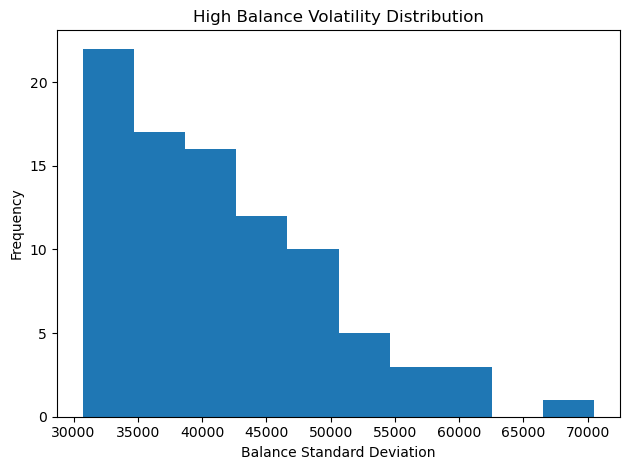

Volatility graph


,TransactionID,CustomerID,AccountID,AccountType,TransactionType,Product,Firm,Region,Manager,TransactionDate,TransactionAmount,AccountBalance,RiskScore,CreditRating,TenureMonths,Transaction_Count,Activity_Level
0,33,CUST6549,ACC12334,Credit,Withdrawal,Savings Account,Firm C,Central,Manager 1,2023-10-21,87480.05448,74008.43310,0.729101,319,200,6,Low
7,27,CUST9731,ACC12182,Loan,Payment,Savings Account,Firm A,North,Manager 2,2023-10-16,51935.49405,140369.89900,0.840356,487,186,4,Low
8,25,CUST8155,ACC11188,Credit,Withdrawal,Personal Loan,Firm E,South,Manager 4,2023-10-24,67602.35218,78966.75783,0.314228,517,207,5,Low
12,195,CUST5920,ACC29396,Credit,Transfer,Personal Loan,Firm D,East,Manager 3,2023-11-20,71906.85992,92425.09938,0.576964,367,135,8,Low
13,111,CUST8529,ACC34821,Credit,Withdrawal,Savings Account,Firm B,South,Manager 4,2023-09-11,63101.51893,52649.22390,0.284473,708,31,4,Low


,TransactionID,CustomerID,AccountID,AccountType,TransactionType,Product,Firm,Region,Manager,TransactionDate,TransactionAmount,AccountBalance,RiskScore,CreditRating,TenureMonths,Transaction_Count,Activity_Level
122,184,CUST8772,ACC16241,Loan,Withdrawal,Mutual Fund,Firm B,Central,Manager 2,2023-02-17,88560.46331,-19222.713000,0.355381,653,147,10,Medium
161,166,CUST8461,ACC28292,Current,Transfer,Mutual Fund,Firm B,Central,Manager 2,2024-04-16,47644.51746,-2250.087452,0.406043,408,24,10,Medium
174,121,CUST7730,ACC26973,Current,Payment,Home Loan,Firm B,North,Manager 1,2024-02-09,48164.13332,-8762.711283,0.816948,475,52,5,Low
199,111,CUST9066,ACC88449,Loan,Payment,Personal Loan,Firm A,East,Manager 3,2023-01-28,44945.55824,-5315.650952,0.388548,619,168,6,Low
215,20,CUST2942,ACC70314,Credit,Withdrawal,Credit Card,Firm D,East,Manager 4,2023-01-09,54119.72962,-31597.850590,0.594390,318,215,4,Low


,AccountID,Balance_STD
3,ACC11188,35494.660810
4,ACC11285,55922.732441
5,ACC11837,60694.391957
6,ACC12182,39337.109206
8,ACC13357,40614.664902


,TransactionID,CustomerID,AccountID,AccountType,TransactionType,Product,Firm,Region,Manager,TransactionDate,TransactionAmount,AccountBalance,RiskScore,CreditRating,TenureMonths,Transaction_Count,Activity_Level,Z_Score


In [ ]:
# ============================================================
# TASK 4: FINANCIAL RISK IDENTIFICATION (10 MARKS)
# ============================================================
# 1. Track frequent large withdrawals and overdrafts
# 2. Calculate balance volatility using standard deviation
# 3. Detect anomalies using Z-score
# 4. Highlight suspicious transaction behavior
# ============================================================




# STEP 1: Load  dataset

print("Dataset shape:")
print(df.shape)
print(df.head(10))



# STEP 2: Large withdrawals (Withdrawal, Payment, Transfer)

withdrawals = df[df['TransactionType'].isin(['Withdrawal', 'Payment', 'Transfer'])]
avg_withdrawal = withdrawals['TransactionAmount'].mean()

large_withdrawals = withdrawals[
    withdrawals['TransactionAmount'] > avg_withdrawal
]

print("\nLarge Withdrawals")
print("Average withdrawal amount:", round(avg_withdrawal, 2))
print("Number of large withdrawals:", large_withdrawals.shape[0])
print(large_withdrawals[['AccountID', 'TransactionAmount']].head())



# STEP 3: Overdraft / Low balance accounts

overdraft_accounts = df[df['AccountBalance'] <= 0]

print("\nOverdraft / Low Balance Accounts")
print("Number of overdraft records:", overdraft_accounts.shape[0])
print(overdraft_accounts[['AccountID', 'AccountBalance']].head())



# STEP 4: Balance volatility (Standard Deviation)

balance_volatility = df.groupby('AccountID').agg(
    Balance_STD=('AccountBalance', 'std')
).reset_index()

avg_volatility = balance_volatility['Balance_STD'].mean()

high_volatility_accounts = balance_volatility[
    balance_volatility['Balance_STD'] > avg_volatility
]

print("\nBalance Volatility")
print("Average balance volatility:", round(avg_volatility, 2))
print("Accounts with high volatility:", high_volatility_accounts.shape[0])
print(high_volatility_accounts.head())



# STEP 5: Anomaly detection using Z-score

mean_amt = df['TransactionAmount'].mean()
std_amt = df['TransactionAmount'].std()

df['Z_Score'] = (df['TransactionAmount'] - mean_amt) / std_amt
anomalies = df[df['Z_Score'].abs() > 3]

print("\nTransaction Anomalies")
print("Mean transaction amount:", round(mean_amt, 2))
print("Std deviation:", round(std_amt, 2))
print("Number of anomalous transactions:", anomalies.shape[0])
print(anomalies[['AccountID', 'TransactionAmount', 'Z_Score']].head())



# STEP 6: Excel

with pd.ExcelWriter("Task_4_Financial_Risk.xlsx", engine="openpyxl") as writer:
    large_withdrawals.to_excel(writer, sheet_name="Large_Withdrawals", index=False)
    overdraft_accounts.to_excel(writer, sheet_name="Overdraft_Accounts", index=False)
    balance_volatility.to_excel(writer, sheet_name="Balance_Volatility", index=False)
    high_volatility_accounts.to_excel(writer, sheet_name="High_Volatility", index=False)
    anomalies.to_excel(writer, sheet_name="Transaction_Anomalies", index=False)

print("\nExcel file saved with 5 sheets")
print("Task_4_Financial_Risk.xlsx")



# STEP 7: Save volatility distribution image

plt.figure()
high_volatility_accounts['Balance_STD'].plot(kind='hist')
plt.title("High Balance Volatility Distribution")
plt.xlabel("Balance Standard Deviation")
plt.tight_layout()
plt.savefig("Task_4_Balance_Volatility.png")
plt.show()

print("Volatility graph")



# FINAL: DISPLAY FULL TABLES

display(large_withdrawals.head())
display(overdraft_accounts.head())
display(high_volatility_accounts.head())
display(anomalies.head())


### Task : 5 Visualisation

Dataset loaded
Rows: 800 | Columns: 15

Transaction type distribution
TransactionType
Withdrawal    207
Payment       200
Deposit       199
Transfer      194
Name: count, dtype: int64


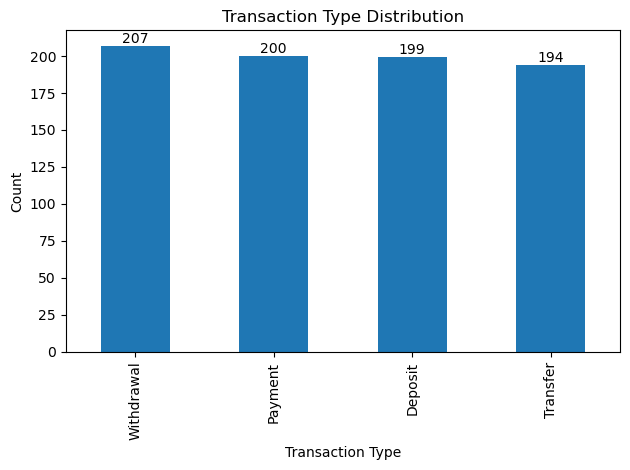


Monthly transaction volume (sample)
Month
2023-01    3.143084e+06
2023-02    2.084763e+06
2023-03    2.702986e+06
2023-04    1.777616e+06
2023-05    2.629305e+06
Name: TransactionAmount, dtype: float64


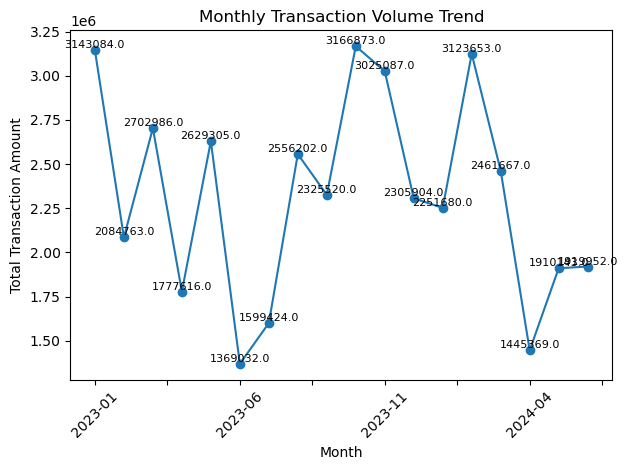


Account balance summary
count       800.000000
mean      72345.657910
std       34070.038539
min      -37293.600250
25%       49157.502723
50%       72789.370195
75%       95352.455698
max      175247.539500
Name: AccountBalance, dtype: float64


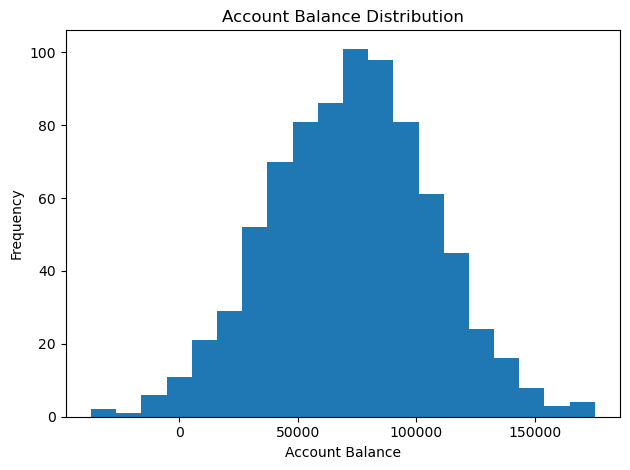


Transaction amount summary
count       800.000000
mean      52247.825769
std       27827.487360
min         375.490904
25%       31692.004800
50%       50249.069385
75%       71913.394570
max      130726.914100
Name: TransactionAmount, dtype: float64


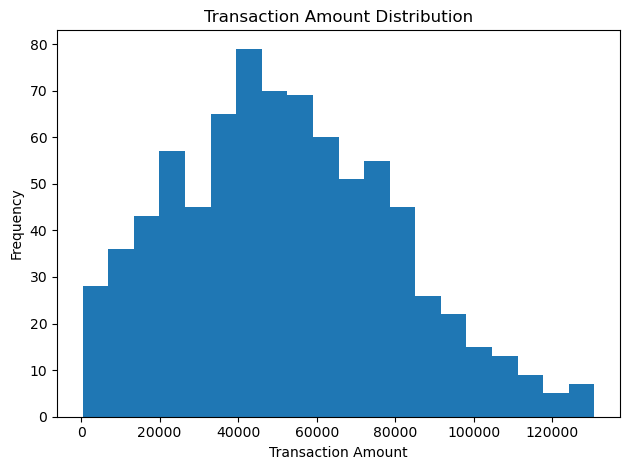


Top 10 most active accounts
AccountID
ACC46655    14
ACC28292    10
ACC16241    10
ACC53466     9
ACC78178     9
ACC29356     9
ACC29396     8
ACC60432     8
ACC87006     8
ACC88252     8
Name: count, dtype: int64


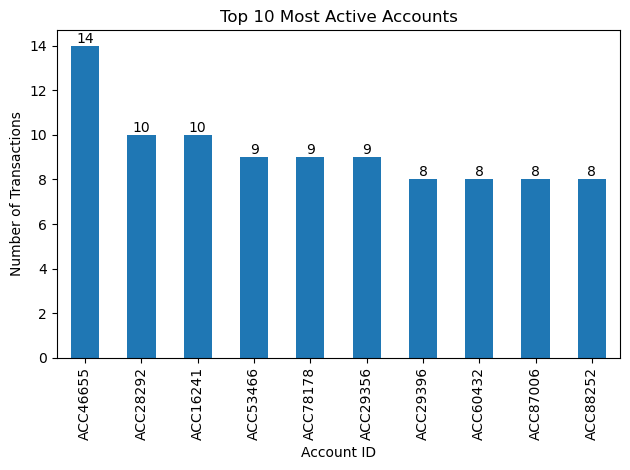

TransactionType
Withdrawal    207
Payment       200
Deposit       199
Transfer      194
Name: count, dtype: int64

Month
2023-01    3.143084e+06
2023-02    2.084763e+06
2023-03    2.702986e+06
2023-04    1.777616e+06
2023-05    2.629305e+06
Name: TransactionAmount, dtype: float64

AccountID
ACC46655    14
ACC28292    10
ACC16241    10
ACC53466     9
ACC78178     9
ACC29356     9
ACC29396     8
ACC60432     8
ACC87006     8
ACC88252     8
Name: count, dtype: int64

In [12]:
# ============================================================
# TASK 5: VISUALISATION (EXPLORATORY DATA ANALYSIS)
# ============================================================
# Objective:
# Conduct exploratory data analysis using visualizations.
# Values are added to all applicable graphs for clarity.
# ============================================================


# STEP 1: Load dataset

df = pd.read_excel("Goldman_Sachs_Cleaned.xlsx")
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

print("Dataset loaded")
print("Rows:", df.shape[0], "| Columns:", df.shape[1])



# STEP 2: Transaction Type Distribution

txn_type_counts = df['TransactionType'].value_counts()

print("\nTransaction type distribution")
print(txn_type_counts)

plt.figure()
ax = txn_type_counts.plot(kind='bar')
plt.title("Transaction Type Distribution")
plt.xlabel("Transaction Type")
plt.ylabel("Count")


for bar in ax.patches:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        int(bar.get_height()),
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.savefig("Task_5_Transaction_Type_Distribution.png")
plt.show()



# STEP 3: Monthly Transaction Volume Trend

df['Month'] = df['TransactionDate'].dt.to_period('M')
monthly_volume = df.groupby('Month')['TransactionAmount'].sum()
monthly_volume.index = monthly_volume.index.astype(str)

print("\nMonthly transaction volume (sample)")
print(monthly_volume.head())

plt.figure()
ax = monthly_volume.plot(marker='o')
plt.title("Monthly Transaction Volume Trend")
plt.xlabel("Month")
plt.ylabel("Total Transaction Amount")
plt.xticks(rotation=45)

# Add values on line points
for x, y in enumerate(monthly_volume):
    ax.text(x, y, round(y, 0), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig("Task_5_Monthly_Transaction_Trend.png")
plt.show()



# STEP 4: Account Balance Distribution (HISTOGRAM)

print("\nAccount balance summary")
print(df['AccountBalance'].describe())

plt.figure()
df['AccountBalance'].plot(kind='hist', bins=20)
plt.title("Account Balance Distribution")
plt.xlabel("Account Balance")
plt.tight_layout()
plt.savefig("Task_5_Account_Balance_Distribution.png")
plt.show()



# STEP 5: Transaction Amount Distribution (HISTOGRAM)

print("\nTransaction amount summary")
print(df['TransactionAmount'].describe())

plt.figure()
df['TransactionAmount'].plot(kind='hist', bins=20)
plt.title("Transaction Amount Distribution")
plt.xlabel("Transaction Amount")
plt.tight_layout()
plt.savefig("Task_5_Transaction_Amount_Distribution.png")
plt.show()



# STEP 6: Top 10 Most Active Accounts

top_accounts = df['AccountID'].value_counts().head(10)

print("\nTop 10 most active accounts")
print(top_accounts)

plt.figure()
ax = top_accounts.plot(kind='bar')
plt.title("Top 10 Most Active Accounts")
plt.xlabel("Account ID")
plt.ylabel("Number of Transactions")

for bar in ax.patches:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        int(bar.get_height()),
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.savefig("Task_5_Top_Active_Accounts.png")
plt.show()



# DISPLAY TABLES

display(txn_type_counts)
display(monthly_volume.head())
display(top_accounts)


### Task : 6 Hypothesis Testing

In [17]:
# ============================================================
# TASK 6: HYPOTHESIS TESTING
# ============================================================
# Objective:
# 1. Test whether high-volume transaction accounts have
#    statistically higher average balances than low-volume accounts.
# 2. Conduct hypothesis testing based on segmentation.
#
# Hypotheses:
# H0 (Null): There is NO significant difference in average balances
#            between high-volume and low-volume transaction accounts.
# H1 (Alternate): High-volume transaction accounts have significantly
#                 higher average balances than low-volume accounts.
# ============================================================


# STEP 1: Load dataset

df = pd.read_excel("Goldman_Sachs_Cleaned.xlsx")

print("Dataset loaded")
print(df.shape)



# STEP 2:account-level summary

account_summary = df.groupby('AccountID').agg(
    Transaction_Count=('TransactionAmount', 'count'),
    Avg_Balance=('AccountBalance', 'mean')
).reset_index()

print("\nAccount-level summary")
print(account_summary.head())



# STEP 3: Segment accounts by transaction volume

# - High-volume  → Transaction count > average transaction count
# - Low-volume   → Transaction count <= average transaction count

avg_txn_count = account_summary['Transaction_Count'].mean()

high_volume_accounts = account_summary[
    account_summary['Transaction_Count'] > avg_txn_count
]

low_volume_accounts = account_summary[
    account_summary['Transaction_Count'] <= avg_txn_count
]

print("\nSegmentation results")
print("Average transaction count:", round(avg_txn_count, 2))
print("High-volume accounts:", high_volume_accounts.shape[0])
print("Low-volume accounts:", low_volume_accounts.shape[0])



# STEP 4: Compare average balances

high_avg_balance = high_volume_accounts['Avg_Balance']
low_avg_balance = low_volume_accounts['Avg_Balance']

print("\nAverage balances")
print("High-volume avg balance:", round(high_avg_balance.mean(), 2))
print("Low-volume avg balance:", round(low_avg_balance.mean(), 2))



# STEP 5: Perform TWO-SAMPLE T-TEST

t_stat, p_value = ttest_ind(
    high_avg_balance,
    low_avg_balance,
    equal_var=False
)

print("\nHypothesis test results")
print("T-statistic:", round(t_stat, 4))
print("P-value:", round(p_value, 4))



# STEP 6: Hypothesis decision (α = 0.05)

alpha = 0.05

print("\nDecision")
if p_value < alpha:
    print("Reject H0: High-volume accounts have significantly higher average balances.")
else:
    print("Fail to reject H0: No significant difference in average balances.")



# DISPLAY TABLES
print("\nHigh-volume accounts sample")
display(high_volume_accounts.head())
print("\nLow-volume accounts sample")
display(low_volume_accounts.head())



# STEP 7: Hypothesis test results for export


hypothesis_result = pd.DataFrame({
    "Metric": [
        "Average Transaction Count Threshold",
        "High-Volume Avg Balance",
        "Low-Volume Avg Balance",
        "T-Statistic",
        "P-Value",
        "Alpha (Significance Level)",
        "Decision"
    ],
    "Value": [
        round(avg_txn_count, 2),
        round(high_avg_balance.mean(), 2),
        round(low_avg_balance.mean(), 2),
        round(t_stat, 4),
        round(p_value, 4),
        alpha,
        "Reject H0" if p_value < alpha else "Fail to Reject H0"
    ]
})


with pd.ExcelWriter("Task_6_Hypothesis_Testing.xlsx", engine="openpyxl") as writer:
    account_summary.to_excel(writer, sheet_name="Account_Summary", index=False)
    high_volume_accounts.to_excel(writer, sheet_name="High_Volume_Accounts", index=False)
    low_volume_accounts.to_excel(writer, sheet_name="Low_Volume_Accounts", index=False)
    hypothesis_result.to_excel(writer, sheet_name="Hypothesis_Result", index=False)


display(hypothesis_result)



Dataset loaded
(800, 15)

Account-level summary
  AccountID  Transaction_Count   Avg_Balance
0  ACC10117                  4  70107.007957
1  ACC10996                  5  43568.008084
2  ACC11062                  2  38137.132610
3  ACC11188                  5  69652.151044
4  ACC11285                  3  97401.348560

Segmentation results
Average transaction count: 4.12
High-volume accounts: 73
Low-volume accounts: 121

Average balances
High-volume avg balance: 72512.19
Low-volume avg balance: 71683.28

Hypothesis test results
T-statistic: 0.3151
P-value: 0.7531

Decision
Fail to reject H0: No significant difference in average balances.

High-volume accounts sample


,AccountID,Transaction_Count,Avg_Balance
1,ACC10996,5,43568.008084
3,ACC11188,5,69652.151044
7,ACC12334,6,78082.517883
8,ACC13357,6,69179.806513
9,ACC15228,5,95389.614144



Low-volume accounts sample


,AccountID,Transaction_Count,Avg_Balance
0,ACC10117,4,70107.007957
2,ACC11062,2,38137.132610
4,ACC11285,3,97401.348560
5,ACC11837,4,84852.733695
6,ACC12182,4,83837.145895


,Metric,Value
0,Average Transaction Count Threshold,4.12
1,High-Volume Avg Balance,72512.19
2,Low-Volume Avg Balance,71683.28
3,T-Statistic,0.3151
4,P-Value,0.7531
5,Alpha (Significance Level),0.05
6,Decision,Fail to Reject H0


#### VIDEO LINK : https://drive.google.com/file/d/1jcgd6hhd4TfbhlbVvl4MUfeoZiOfO_Iw/view?usp=sharing